In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import copernicusmarine as cm
import matplotlib.pyplot as plt
import geoplot
import matplotlib as mpl
%matplotlib inline

In [2]:
#monthly bottom temp data from copernicus
#ds_gl = cm.open_dataset(dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m")

In [ ]:
#bt_gl = ds_gl.bottomT.sel(latitude = slice(30, 48), longitude = slice(-80, -60))

In [ ]:
#bt_gl.to_netcdf('bt_glorys_M.nc')

In [ ]:
#opendap_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/regrid/ocean_monthly.199301-201912.tob.nc"
#bt_m6 = xr.open_dataset(opendap_url)

In [ ]:
#bt_m6 = xr.open_dataset('ocean_monthly.199301-201912.tob.nc')

In [ ]:
#bt_mom6 = bt_m6.sel(lat = slice(30,48), lon = slice(260,300))

In [ ]:
#bt_mom6.to_netcdf('bt_mom6_M.nc')

In [78]:
bt_gl = xr.open_dataset('bt_glorys_M.nc')
bt_m6 = xr.open_dataset('bt_mom6_M.nc')

In [15]:
360-280

80

In [ ]:
## dont need to do this for mean bt across each strata
gl_regrid = np.empty([324, 774, 844])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(bt_mom6.lat.values, bt_mom6.lon.values-360)
for i in range(324):
    interp_to_mom6 = RegularGridInterpolator((bt_glorys.latitude.values, bt_glorys.longitude.values), bt_glorys.bottomT[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))

In [41]:
strata = gpd.read_file('EcoMon_strata/EcoMon_Strata.shp')

In [42]:
# Get the region of interest
region = regionmask.from_geopandas(strata)

In [79]:
# Create the mask
mask = region.mask(bt_gl.longitude, bt_gl.latitude)

In [7]:
mask2 = region.mask(bt_m6.lon.astype('f4'), bt_m6.lat.astype('f4'))#, wrap_lon = False)

In [8]:
bt_gl_strata = xr.Dataset(data_vars = {'01': (['time','latitude','longitude'], bt_gl.bottomT.where(mask == region.numbers[0]).data)},
                          coords = {'time': bt_gl.time,
                                    'latitude': bt_gl.latitude,
                                    'longitude': bt_gl.longitude})

In [9]:
for i in np.arange(1, len(region.numbers)):
    masked_ds = bt_gl.where(mask == region.numbers[i])
    strata_bt_gl_n = xr.Dataset(data_vars = {strata.STRATA[i]: (['time','latitude','longitude'], bt_gl.bottomT.where(mask == region.numbers[i]).data)},
                          coords = {'time': bt_gl.time,
                                    'latitude': bt_gl.latitude,
                                    'longitude': bt_gl.longitude})
    bt_gl_strata = xr.merge([bt_gl_strata, strata_bt_gl_n])

In [10]:
bt_m6_strata = xr.Dataset(data_vars = {'01': (['time','latitude','longitude'], bt_m6.tob.where(mask2 == region.numbers[0]).data)},
                          coords = {'time': bt_m6.time,
                                    'latitude': bt_m6.lat.values,
                                    'longitude': bt_m6.lon.values})

In [11]:
for i in np.arange(1, len(region.numbers)):
    masked_ds = bt_m6.where(mask2 == region.numbers[i])
    strata_bt_m6_n = xr.Dataset(data_vars = {strata.STRATA[i]: (['time','latitude','longitude'], bt_m6.tob.where(mask2 == region.numbers[i]).data)},
                          coords = {'time': bt_m6.time,
                                    'latitude': bt_m6.lat.values,
                                    'longitude': bt_m6.lon.values})
    bt_m6_strata = xr.merge([bt_m6_strata, strata_bt_m6_n])

In [12]:
bias_seasons = bt_m6_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time'])


In [13]:
bias_seasons

<xarray.DataArray '01' (season: 4)>
array([ 0.14507389,  0.2989025 ,  0.79251957, -0.26698017], dtype=float32)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [14]:
bias = bt_m6_strata[strata.STRATA[0]].mean() - bt_gl_strata[strata.STRATA[0]].mean()
bias_seasons = bt_m6_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time'])
bias_winter = bias_seasons[0]
bias_spring = bias_seasons[2]
bias_summer = bias_seasons[1]
bias_fall = bias_seasons[3]

#1 Bias
for i in np.arange(1, len(region.numbers)):
    bias_n = bt_m6_strata[strata.STRATA[i]].mean() - bt_gl_strata[strata.STRATA[i]].mean()
    bias_seasons_n = bt_m6_strata[strata.STRATA[i]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[i]].groupby('time.season').mean(['latitude','longitude','time'])
    bias_winter = np.append(bias_winter, bias_seasons_n[0])
    bias_spring = np.append(bias_spring, bias_seasons_n[2])
    bias_summer = np.append(bias_summer, bias_seasons_n[1])
    bias_fall = np.append(bias_fall, bias_seasons_n[3])
    bias = np.append(bias, bias_n)

In [15]:
strata['bias'] = bias
strata['bias_djf'] = bias_winter
strata['bias_mam'] = bias_spring
strata['bias_jja'] = bias_summer
strata['bias_son'] = bias_fall

In [16]:
strata

,STRATA,geometry,bias,bias_djf,bias_mam,bias_jja,bias_son
0,01,"POLYGON ((-74.80749 35.76881, -74.80510 35.763...",0.250170,0.145074,0.792520,0.298903,-0.266980
1,02,"POLYGON ((-75.21358 35.50122, -75.21112 35.504...",0.705049,1.135070,2.472097,-0.487873,-0.462845
2,03,"POLYGON ((-75.27774 35.14312, -75.27812 35.142...",-0.740721,0.631741,1.044252,-4.067873,-0.777555
3,04,"POLYGON ((-74.37205 37.45870, -74.37800 37.453...",0.092263,-0.042995,0.891421,0.284733,-0.811557
4,05,"POLYGON ((-74.63894 37.71186, -74.63976 37.710...",1.583154,1.116408,2.826412,1.770176,0.446980
5,06,"POLYGON ((-75.71381 37.50764, -75.71381 37.504...",-0.724605,-0.396599,0.514084,-2.667688,-0.586178
6,07,"POLYGON ((-73.32678 38.45735, -73.33272 38.453...",0.656456,0.885162,1.333096,0.494556,-0.132639
7,08,"POLYGON ((-74.44489 39.04869, -74.41609 39.033...",0.971866,0.831870,1.308310,1.275729,0.341822
8,09,"POLYGON ((-75.10498 37.82012, -75.10795 37.812...",-0.383771,-0.294537,0.475975,-1.303205,-0.636110
9,10,"POLYGON ((-72.73364 39.16571, -72.70262 39.142...",-0.137446,0.321298,0.586091,-0.903450,-0.603356


<Axes: >

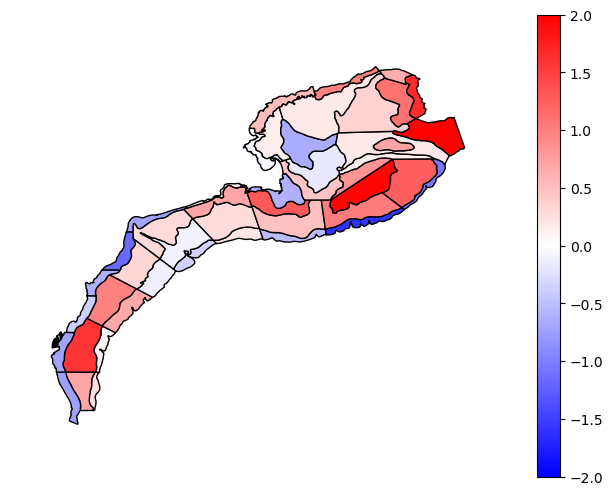

In [17]:
norm = mpl.colors.Normalize(vmin=-2.,vmax=2.)
geoplot.choropleth(df = strata, hue = 'bias',cmap = 'bwr', norm = norm, legend =True)

Text(0.5, 1.0, 'Bias SON')

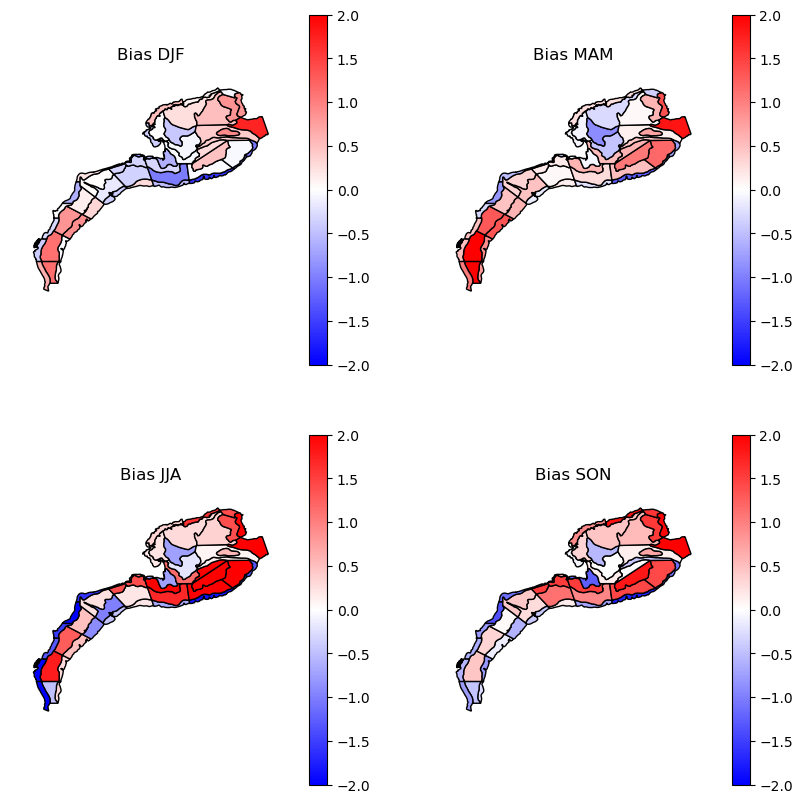

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

norm = mpl.colors.Normalize(vmin=-2.,vmax=2.)
geoplot.choropleth(df = strata, hue = 'bias_djf',cmap = 'bwr', norm = norm, legend =True, ax=ax[0,0])
ax[0,0].set_title('Bias DJF')

geoplot.choropleth(df = strata, hue = 'bias_mam',cmap = 'bwr', norm = norm, legend =True, ax=ax[0,1])
ax[0,1].set_title('Bias MAM')

geoplot.choropleth(df = strata, hue = 'bias_jja',cmap = 'bwr', norm = norm, legend =True, ax=ax[1,0])
ax[1,0].set_title('Bias JJA')

geoplot.choropleth(df = strata, hue = 'bias_son',cmap = 'bwr', norm = norm, legend =True, ax=ax[1,1])
ax[1,1].set_title('Bias SON')

In [5]:
#import xarray as xr

# lazy loading of data
ds = xr.open_dataset(
    "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/forecast/regrid/tob_forecast_i199303.nc"
)

# loading a slice to memory
#da_load = ds["tob"].load()


OSError: [Errno -68] NetCDF: I/O failure: b'http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/forecast/regrid/tob_forecast_i199303.nc'

In [25]:
ds = xr.open_dataset('tob_forecast/March_init/tob_forecast_i199303.nc')
ds_short = ds.sel(lat = slice(33,47), lon = slice(280, 300))
tob = ds_short.load()
tob

<xarray.Dataset>
Dimensions:   (lead: 12, member: 10, lon: 248, lat: 224)
Coordinates:
    init      datetime64[ns] 1993-03-01
  * lead      (lead) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * member    (member) int32 1 2 3 4 5 6 7 8 9 10
    month     int32 3
  * lon       (lon) float64 280.0 280.1 280.2 280.3 ... 299.7 299.8 299.9 300.0
  * lat       (lat) float64 33.0 33.07 33.13 33.19 ... 46.81 46.87 46.93 46.99
Data variables:
    tob       (member, lead, lat, lon) float32 nan nan nan ... 3.525 5.036 5.817
    tob_anom  (member, lead, lat, lon) float32 nan nan nan ... -0.1048 -0.1468
Attributes:
    NumFilesInSet:    1
    title:            NWA12_forecast_2023-04_1994-03-e01
    grid_type:        regular
    grid_tile:        N/A
    history:          Derived and written at NOAA Physical Science Laboratory
    NCO:              netCDF Operators version 5.1.5 (Homepage = http://nco.s...
    contact:          chia-wei.hsu@noaa.gov
    dataset:          regional mom6 regrid
    paper_reference:  https://doi.org/10.5194/egusphere-2024-394
    data_reference:   https://doi.org/10.5281/zenodo.10642294

In [30]:
file = 'tob_forecast/March_init/tob_forecast_i' + str(i) + '03.nc'
ds = xr.open_dataset(file)
ds_short = ds.sel(lat = slice(33,47), lon = slice(280, 300))

In [39]:
tob.init.values

numpy.datetime64('1993-03-01T00:00:00.000000000')

In [40]:
tob.expand_dims({'init': tob.init.values})

TypeError: The value of new dimension init must be an iterable or an int

In [20]:
year_list = np.arange(1994, 2002)
for i in year_list:
    file = 'tob_forecast/March_init/tob_forecast_i' + str(i) + '03.nc'
    ds = xr.open_dataset(file)
    ds_short = ds.sel(lat = slice(33,47), lon = slice(280, 300))
    ds_load = ds_short.load()
    tob=xr.merge(tob, ds_short)

TypeError: objects must be an iterable containing only Dataset(s), DataArray(s), and dictionaries.

In [44]:
tob

<xarray.Dataset>
Dimensions:   (lead: 12, member: 10, lon: 248, lat: 224)
Coordinates:
    init      datetime64[ns] 1993-03-01
  * lead      (lead) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * member    (member) int32 1 2 3 4 5 6 7 8 9 10
    month     int32 3
  * lon       (lon) float64 280.0 280.1 280.2 280.3 ... 299.7 299.8 299.9 300.0
  * lat       (lat) float64 33.0 33.07 33.13 33.19 ... 46.81 46.87 46.93 46.99
Data variables:
    tob       (member, lead, lat, lon) float32 nan nan nan ... 3.525 5.036 5.817
    tob_anom  (member, lead, lat, lon) float32 nan nan nan ... -0.1048 -0.1468
Attributes:
    NumFilesInSet:    1
    title:            NWA12_forecast_2023-04_1994-03-e01
    grid_type:        regular
    grid_tile:        N/A
    history:          Derived and written at NOAA Physical Science Laboratory
    NCO:              netCDF Operators version 5.1.5 (Homepage = http://nco.s...
    contact:          chia-wei.hsu@noaa.gov
    dataset:          regional mom6 regrid
    paper_reference:  https://doi.org/10.5194/egusphere-2024-394
    data_reference:   https://doi.org/10.5281/zenodo.10642294

In [80]:
mask2 = region.mask(tob.lon.astype('f4'), tob.lat.astype('f4'))
mask1 = region.mask(bt_gl.longitude, bt_gl.latitude)

In [57]:
np.shape(anoms.data)

(10, 12)

In [54]:
masked_ds = tob.where(mask2 == region.numbers[0])
anoms = tob.tob_anom.where(mask2 == region.numbers[0]).mean(['lat','lon'])
tob_new = xr.Dataset(data_vars = {'tob_anom': (['init','member','lead'], anoms.data)},
                     coords = {'init': anoms.init.values,
                               'member': anoms.member.values,
                               'lead': anoms.lead.values})

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['init', 'member', 'lead'], array([[-1.2038597 , -1.2137657 , -0.73872185, -0.18427889,  0.01586648,
        -0.319645  , -0.704469  , -0.97117007, -0.4550626 , -0.439064  ,
         0.08044727, -0.11630467],
       [-1.5472552 , -0.88270974, -1.0595033 , -0.8370921 , -0.6034317 ,
        -0.43320638, -0.14018247, -0.08046215, -0.8324213 , -0.67770606,
        -0.7046779 , -0.7695417 ],
       [-1.3914032 , -1.1596993 , -0.98864657, -0.72252876, -0.05938519,
        -0.16815633, -0.39866802,  0.2210428 , -0.24284026, -0.67395484,
        -0.6883996 , -0.64032924],
       [-1.2562187 , -1.0140748 , -1.0988938 , -0.47100618,  0.78568554,
         0.21651274, -0.19187301,  0.21022412, -0.5510693 , -0.59474367,
        -0.5910149 , -1.0902898 ],
       [-1.3557726 , -1.1472756 , -1.0028569 , -0.55078244, -0.03677477,
        -0.35270587, -0.41749522, -0.4197518 , -0.9902989 , -0.7667174 ,
        -0.15685277, -0.0453858 ],
       [-1.2291545 , -1.4223878 , -0.510302  , -0.4430484 ,  0.04658637,
        -0.3945866 , -0.6259022 , -0.60911447, -0.5344604 , -0.1427005 ,
        -0.6952001 , -0.6589472 ],
       [-1.3662684 , -1.0321336 , -0.4123928 , -0.30107835, -0.2209163 ,
         0.13252142, -0.5344048 , -1.0492638 , -1.1160916 , -1.0225209 ,
        -0.90576017, -0.2150509 ],
       [-1.6680486 , -1.4453827 , -1.3315016 , -0.937738  , -0.4274692 ,
        -0.54901123, -0.7008253 , -0.9045537 , -0.7571539 , -0.97420734,
        -0.95551735, -0.8836635 ],
       [-1.6192876 , -1.4374758 , -1.1248357 , -0.526584  ,  0.4371949 ,
         0.0121749 , -0.6234521 , -1.2366031 , -1.3135504 , -1.1999172 ,
        -0.42162317, -0.49997595],
       [-0.9935673 , -1.114656  , -1.1665996 , -0.6600315 , -0.51544815,
        -0.2122605 , -0.17424014, -0.61346334, -0.8335539 , -0.00251604,
        -0.44299227, -0.05127585]], dtype=float32)) to Variable.

In [96]:
bt_gl_anom = bt_gl.groupby('time.month') - bt_gl.groupby('time.month').mean('time')

In [97]:
bt_gl_anom

<xarray.Dataset>
Dimensions:    (latitude: 217, longitude: 241, time: 342)
Coordinates:
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-06-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Data variables:
    bottomT    (time, latitude, longitude) float32 0.4449 0.1299 ... 1.057 1.061

In [95]:
np.shape(bt_gl_anom.bottomT.where(mask1 == region.numbers[j]).mean(['latitude','longitude']))

(342, 12)

In [98]:


tob_anoms = np.empty([len(region.numbers), 342])
for j in region.numbers:
    masked_ds2 = bt_gl_anom.where(mask1 == region.numbers[j])
    tob_anomaly = bt_gl_anom.bottomT.where(mask1 == region.numbers[j]).mean(['latitude','longitude']).data
    tob_anoms[j,:] = tob_anomaly


In [99]:
tob_anoms_ecomon_gl = xr.Dataset(data_vars = {'tob_anom': (['region','time'], tob_anoms)},
                              coords = {'region': region.numbers,
                                        'time': bt_gl_anom.time})

In [157]:
ds

<xarray.Dataset>
Dimensions:   (lead: 12, member: 10, lon: 774, lat: 844)
Coordinates:
    init      datetime64[ns] ...
  * lead      (lead) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * member    (member) int32 1 2 3 4 5 6 7 8 9 10
    month     int32 ...
  * lon       (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
  * lat       (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
Data variables:
    tob       (member, lead, lat, lon) float32 ...
    tob_anom  (member, lead, lat, lon) float32 ...
Attributes:
    NumFilesInSet:    1
    title:            NWA12_forecast_2023-04_1994-03-e01
    grid_type:        regular
    grid_tile:        N/A
    history:          Derived and written at NOAA Physical Science Laboratory
    NCO:              netCDF Operators version 5.1.5 (Homepage = http://nco.s...
    contact:          chia-wei.hsu@noaa.gov
    dataset:          regional mom6 regrid
    paper_reference:  https://doi.org/10.5194/egusphere-2024-394
    data_reference:   https://doi.org/10.5281/zenodo.10642294

In [158]:
year_list = np.arange(1993, 2023)
tob_y_r_m_l = np.empty([len(year_list),47,10,12])

for i in np.arange(len(year_list)):
    file = 'tob_forecast/March_init/tob_forecast_i' + str(year_list[i]) + '03.nc'
    ds = xr.open_dataset(file)
    #region, member, lead
    tob_anoms = np.empty([len(region.numbers), 10,12])
    for j in region.numbers:
        masked_ds = ds.where(mask2 == region.numbers[j])
        tob_anom = ds.tob_anom.where(mask2 == region.numbers[j]).mean(['lat','lon']).data
        tob_anoms[j,:,:] = tob_anom
    tob_y_r_m_l[i,:,:,:] = tob_anoms

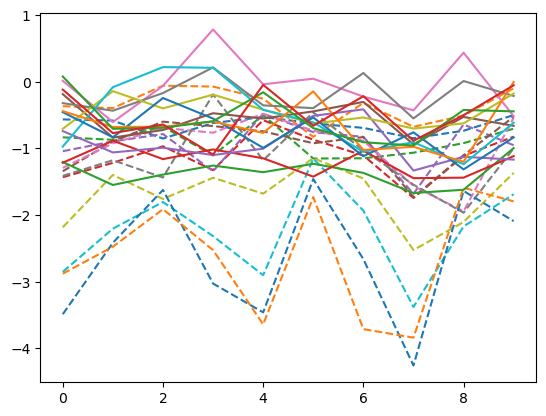

In [153]:
i = 0
file = 'tob_forecast/March_init/tob_forecast_i' + str(year_list[i]) + '03.nc'
ds = xr.open_dataset(file)
masked_ds = tob.where(mask2 == region.numbers[0])
tob_anom = tob.tob_anom.where(mask2 == region.numbers[j]).mean(['lat','lon']).data

i = 2
file = 'tob_forecast/March_init/tob_forecast_i' + str(year_list[i]) + '03.nc'
ds = xr.open_dataset(file)
masked_ds2 = tob.where(mask2 == region.numbers[0])
tob_anom2 = tob.tob_anom.where(mask2 == region.numbers[0]).mean(['lat','lon']).data

plt.plot(tob_anom, linestyle = 'dashed')
plt.plot(tob_anom2)

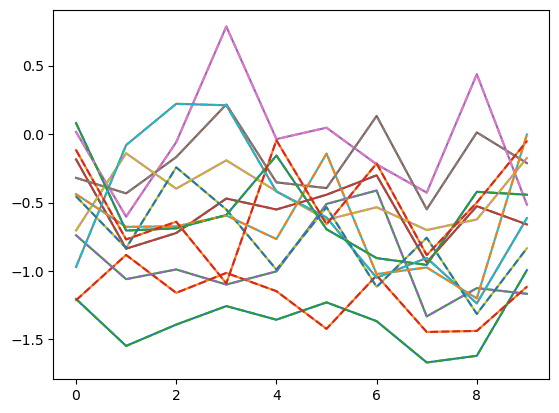

In [156]:
plt.plot(tob_anoms_ecomon_march.tob_anom[2,0,:,:])
plt.plot(tob_anoms_ecomon_march.tob_anom[0,0,:,:], linestyle = 'dashed')

In [159]:
tob_anoms_ecomon_march = xr.Dataset(data_vars = {'tob_anom': (['init','region','member','lead'], tob_y_r_m_l)},
                              coords = {'init': year_list,
                                        'region': region.numbers,
                                        'member': np.arange(1,11),
                                        'lead': np.arange(0,12)})

In [160]:
tob_time_series = tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(1993,1993)).tob_anom.values[0][0]

for i in np.arange(1994,2023):
    tob_time_series = np.append(tob_time_series, tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(i,i)).tob_anom.values[0][0])

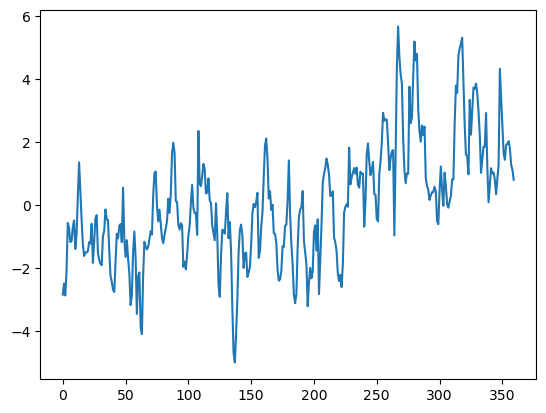

In [161]:
plt.plot(tob_time_series)

In [174]:
# This works...but, no I want a time series with all the leads 0, 1, 2 etc.
glorys_ts = np.empty([47, 342])
m6_ts = np.empty([47, 360])

for a in region.numbers:
    glorys_region = tob_anoms_ecomon_gl.sel(region = slice(a,a))
    m6_region = tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(1993,1993)).tob_anom.values[0][0]
    for i in np.arange(1994,2023):
        m6_region = np.append(m6_region, tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(i,i)).tob_anom.values[0][0])
    glorys_ts[a, :] = glorys_region.tob_anom.data
    m6_ts[a, :] = m6_region

In [ ]:
# This works...but, no I want a time series with all the leads 0, 1, 2 etc.
glorys_ts = np.empty([47,12, 29])
m6_ts = np.empty([47,12, 30])

def is_month(month_test, month):
    return (month_test == month )
    
for a in region.numbers:
    glorys_region = tob_anoms_ecomon_gl.sel(region = slice(a,a))
    m6_region = tob_anoms_ecomon_march.sel(region = slice(a,a))
    for b in np.arange(0,12): # for each of the leads
        glorys_region_lead = glorys_region.sel(time=is_month(glorys_region['time.month'], 3+b))
        m6_region_lead = m6_region.sel(lead = slice(b,b)).mean('member').tob_anom
    for i in np.arange(1994,2023):
        m6_region = np.append(m6_region, tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(i,i)).tob_anom.values[0][0])
    glorys_ts[a, :] = glorys_region.tob_anom.data
    m6_ts[a, :] = m6_region

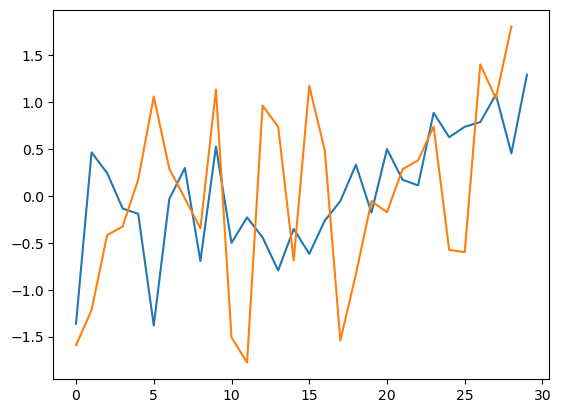

In [206]:
a = 0
b = 0
def is_month(month_test, month):
    return (month_test == month )
glorys_region = tob_anoms_ecomon_gl.sel(region = slice(a,a))
m6_region = tob_anoms_ecomon_march.sel(region = slice(a,a))
glorys_region_lead = glorys_region.sel(time=is_month(glorys_region['time.month'], 3+b))
m6_region_lead = m6_region.sel(lead = slice(b,b)).mean('member').tob_anom
plt.plot(np.squeeze(m6_region_lead.values))
plt.plot(np.squeeze(glorys_region_lead.tob_anom.values))

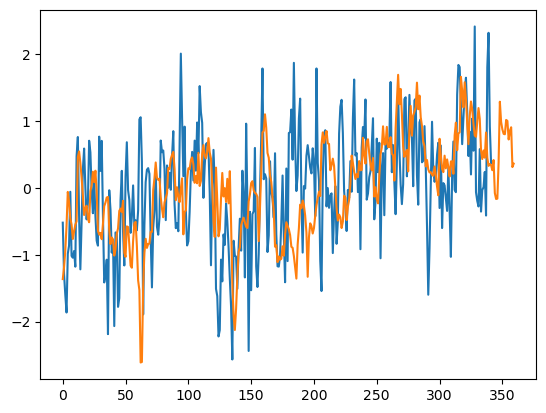

In [175]:
glorys_ts = np.empty([47, 342])
m6_ts = np.empty([47, 360])

for a in region.numbers:
    glorys_region = tob_anoms_ecomon_gl.sel(region = slice(a,a), time.month = slice()
    m6_region = tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(lead = slice(0,0)).tob_anom.values[0][0]
    for i in np.arange(1,12):
        m6_region = np.append(m6_region, tob_anoms_ecomon_march.sel(region = slice(a,a)).mean('member').sel(init = slice(i,i)).tob_anom.values[0][0])


In [182]:
import pandas as pn
m6_march_init_time = pn.date_range(start = '1993-03', end = '2023-03', freq = 'M')

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_1216\3886462385.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m6_march_init_time = pn.date_range(start = '1993-03', end = '2023-03', freq = 'M')


In [183]:
len(m6_march_init_time)

360

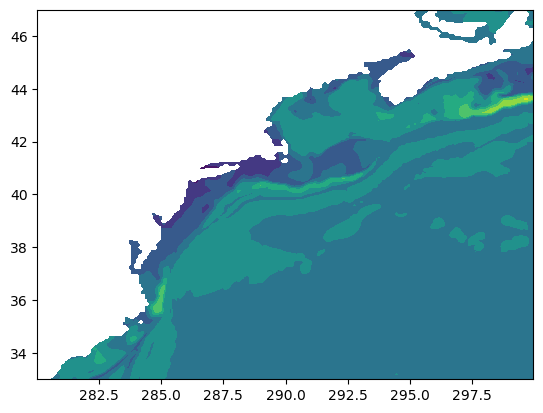

In [17]:
plt.contourf(tob_1994_3.lon.sel(lon=slice(280,300)), 
             tob_1994_3.lat.sel(lat=slice(33,47)),
             tob_1994_3.tob_anom.sel(member = 1, lead = 0, lon = slice(280,300), lat = slice(33, 47)))

In [15]:
tob_1994_3.member

<xarray.DataArray 'member' (member: 10)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
Coordinates:
    init     datetime64[ns] ...
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
    month    int32 ...